In [48]:
import numpy as np
import os
import re
import seaborn as sns

from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

In [78]:
# Load the data
data_dir = "../data/AAMAS"
dset_idx = 3
which_dset = "00037-0000000%d.cat" % dset_idx

dset_sizes = [(201, 613), (161, 442), (667, 526)]
# Yes, maybe, no answer, no
rating_scores = [1.0, .5, 0.0, -1.0]

if dset_idx == 3:
    # Yes, maybe, no, conflict
    rating_scores = [1.0, .5, -1.0, 0.0]

agent_idx = 0
with open(os.path.join(data_dir, which_dset)) as f:
    ratings = np.zeros(dset_sizes[dset_idx-1])
    for l in f.readlines():
        if not l.startswith("#"):
            l = re.sub("[0-9]*: ", "", l)
            bracket_list = re.compile("\{[0-9, ]*\}|[0-9]+")
            lists = bracket_list.findall(l)
            if len(lists) != 4:
                print(lists)
                print(l)
                print("PROBLEM")
            for idx, list_of_prefs in enumerate(lists):
                if list_of_prefs != '{}':
                    list_of_prefs = re.sub("[\{\}]", "", list_of_prefs)
                    prefs = [int(x)-1 for x in list_of_prefs.split(",")]
                    ratings[agent_idx, prefs] = rating_scores[idx]
            agent_idx += 1

In [79]:
np.save(os.path.join(data_dir, "ratings_%d.npy" % dset_idx), ratings)

In [80]:
# Use https://dl.acm.org/doi/pdf/10.1145/1553374.1553452 to get prob model for CVaR objectives
gen = np.random.default_rng(seed=0)
q = 20
x = gen.normal(loc=0, scale=1e-3, size=(ratings.shape[0], q))
sig = .05

In [81]:
x

array([[ 1.25730221e-04, -1.32104863e-04,  6.40422650e-04, ...,
        -3.16300156e-04,  4.11630536e-04,  1.04251337e-03],
       [-1.28534663e-04,  1.36646347e-03, -6.65194673e-04, ...,
        -1.29613634e-04,  7.83975470e-04,  1.49343115e-03],
       [-1.25906553e-03,  1.51392377e-03,  1.34587542e-03, ...,
         6.96042724e-04, -1.18411797e-03, -6.61702572e-04],
       ...,
       [-9.02690927e-04,  9.37403974e-04,  9.56067063e-04, ...,
         1.11817382e-03, -1.54199682e-04,  2.54180358e-05],
       [ 2.62712982e-04,  2.24919949e-04,  8.63618968e-05, ...,
         4.42117853e-04,  9.69861933e-04, -1.11241352e-03],
       [-7.35110772e-04, -5.93191918e-04,  1.13752576e-04, ...,
        -7.00356874e-04, -4.90968554e-04, -1.48581079e-03]])

In [82]:
n_iter = 100

lr = 1e-4

for i in tqdm(range(n_iter)):
#     item_idx = gen.integers(ratings.shape[1])
    for item_idx in range(ratings.shape[1]):
        # pick out the users where this item was rated
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
#         print(observed)
#         print(x[observed])
        if len(observed):
            Cj = np.matmul(x[observed], x[observed].T) + (sig**2)*np.eye(len(observed))
#             print(Cj)
            Cinv = np.linalg.inv(Cj)
            yobs = ratings[observed, item_idx]
    #         print(yobs)
            G = np.outer(yobs, yobs)
            G = np.matmul(Cinv, G)
            G = np.matmul(G, Cinv)
            G -= Cinv
            grad = np.matmul(-G, x[observed])

            x[observed] -= lr*grad

  0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
# For each item, we can sample the rating for each user. It is by section 3.1, the prediction of user rating section.
print(x.shape)
k = np.matmul(x, x.T)
s = k + (sig**2)*np.eye(k.shape[0])
mu_matrix = np.zeros(ratings.shape)
zeta_matrix = np.zeros(ratings.shape)
for item_idx in tqdm(range(ratings.shape[1])):
    for user_idx in range(ratings.shape[0]):
        observed = np.where(np.abs(ratings[:, item_idx]) > 1e-4)[0]
        sobs = s[observed, :][:, observed]
        final_s = np.matmul(np.linalg.inv(sobs), k[observed, user_idx])
        mu = np.dot(final_s, ratings[observed, item_idx])
        mu_matrix[user_idx, item_idx] = mu
        zeta_matrix[user_idx, item_idx] = k[user_idx, user_idx] + sig**2 - np.dot(k[observed, user_idx], final_s)
        
# cov_mat = np.matmul(x, x.T) + (sig**2)*np.eye(x.shape[0])
# zero_vec = np.zeros(x.shape[0])

(667, 20)


  0%|          | 0/526 [00:00<?, ?it/s]

In [84]:
np.save(os.path.join(data_dir, "mu_matrix_%d.npy" % dset_idx), mu_matrix)
np.save(os.path.join(data_dir, "zeta_matrix_%d.npy" % dset_idx), zeta_matrix)

In [93]:
ratings[np.where(ratings > .5)].shape

(6665,)

In [94]:
mu_matrix[np.where(ratings == 1)][:300]

array([-7.82595666e-01, -9.49701474e-01, -8.63080155e-01, -7.11956223e-01,
       -6.62208094e-01, -5.55182234e-01,  3.65711030e-01,  6.88942575e-01,
        1.31609686e-01, -7.93921557e-01,  3.11553308e-01,  4.97713798e-01,
        6.16549406e-01, -5.88141446e-01,  7.99683303e-01, -4.09261306e-01,
       -3.58425982e-01, -1.44308933e-01, -7.85643181e-01,  9.15239815e-01,
        4.12078698e-01,  8.53442885e-01,  1.45487714e-01,  1.38522053e-01,
        1.12499062e+00, -5.72806046e-01,  6.43900552e-01, -4.78208311e-01,
       -2.08070794e-01, -5.61838505e-01, -5.11127539e-01, -4.26639376e-01,
        2.71069772e-01,  8.73428142e-01, -1.30637189e-01,  1.10271852e+00,
       -2.54017071e-01, -5.12118856e-01,  4.39566798e-02,  1.23874228e+00,
       -1.71406061e-01, -3.12844073e-01,  1.07128820e+00,  1.04576835e+00,
       -1.97453317e-01,  1.59088408e-01,  3.70741113e-01,  8.84302374e-01,
       -3.36355965e-01,  1.99348149e+00,  1.89502857e+00,  2.76547596e-01,
        7.80480377e-01, -

<Axes: ylabel='Count'>

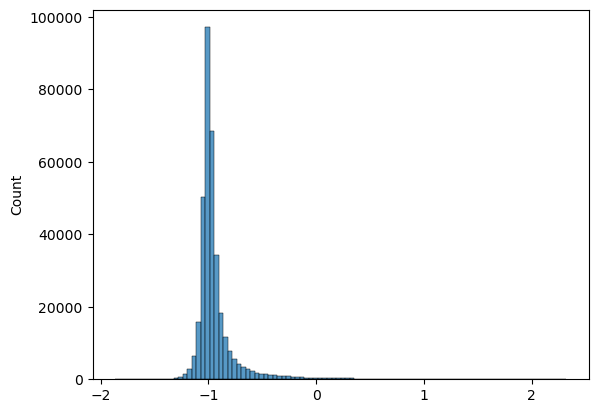

In [87]:
sns.histplot(mu_matrix.flatten(), bins=100)

<Axes: ylabel='Count'>

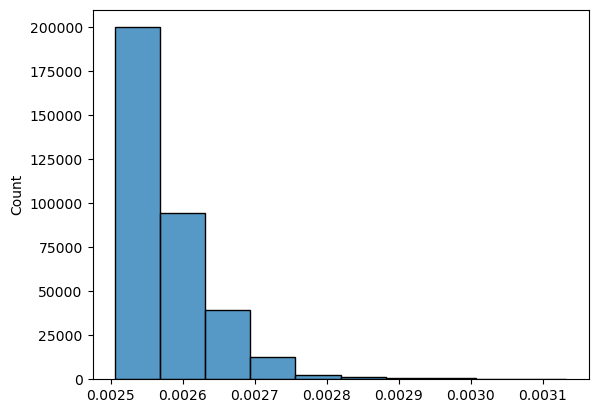

In [88]:
sns.histplot(zeta_matrix.flatten(), bins=10)

In [89]:
np.max(zeta_matrix, axis=0)

array([0.00296505, 0.00296334, 0.00296435, 0.00295996, 0.00295934,
       0.00296299, 0.00295931, 0.0029594 , 0.00296597, 0.00297264,
       0.00295932, 0.00296923, 0.00296814, 0.00295931, 0.00296012,
       0.00295932, 0.00296251, 0.00295974, 0.00296325, 0.00297145,
       0.00295931, 0.0030498 , 0.00295968, 0.00295931, 0.00297273,
       0.00295999, 0.00295989, 0.00296557, 0.0029594 , 0.00306311,
       0.00296902, 0.00296407, 0.00295937, 0.0029602 , 0.00296237,
       0.00296058, 0.00295931, 0.00295931, 0.00295931, 0.00295955,
       0.0029636 , 0.00295938, 0.00295931, 0.00296003, 0.00296141,
       0.00296319, 0.00296025, 0.00296027, 0.00296245, 0.00296156,
       0.00295938, 0.00296021, 0.00296334, 0.00295934, 0.00295954,
       0.00296074, 0.00295932, 0.00295931, 0.00296271, 0.00310144,
       0.00296818, 0.00295972, 0.00296031, 0.00295961, 0.00295976,
       0.00296168, 0.00295946, 0.00295964, 0.00295935, 0.0029677 ,
       0.0029684 , 0.00295998, 0.00296061, 0.00296353, 0.00297

# Now we'll cluster these and make groups for both getting COIs and for the GESW

In [36]:
# cluster ratings
ratings

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [37]:
from sklearn.cluster import SpectralCoclustering
clustering = SpectralCoclustering(n_clusters=10, random_state=0).fit(ratings)

In [38]:
clustering.row_labels_

array([1, 2, 0, 7, 0, 0, 5, 0, 2, 5, 5, 4, 8, 3, 2, 4, 8, 1, 1, 6, 7, 1,
       0, 1, 0, 4, 8, 8, 9, 0, 8, 5, 9, 4, 1, 8, 1, 2, 0, 9, 9, 4, 1, 6,
       1, 7, 3, 2, 2, 1, 8, 1, 8, 5, 8, 3, 7, 6, 5, 8, 7, 1, 1, 5, 5, 2,
       2, 1, 1, 1, 1, 6, 8, 1, 3, 6, 8, 8, 7, 4, 7, 1, 4, 8, 5, 8, 1, 7,
       2, 3, 0, 2, 5, 2, 1, 7, 8, 1, 7, 3, 8, 1, 8, 9, 2, 8, 8, 2, 1, 7,
       2, 8, 5, 1, 9, 6, 8, 2, 6, 6, 8, 1, 2, 3, 1, 8, 7, 2, 0, 5, 6, 5,
       4, 8, 8, 6, 7, 1, 6, 6, 5, 6, 6, 7, 6, 3, 8, 0, 2, 9, 1, 6, 2, 1,
       6, 6, 4, 5, 2, 8, 6, 6, 0, 4, 1, 3, 3, 6, 6, 5, 3, 4, 2, 8, 0, 9,
       0, 1, 9, 7, 8, 4, 5, 6, 3, 2, 1, 1, 4, 2, 0, 1, 0, 1, 0, 4, 5, 3,
       9, 3, 8, 6, 2, 2, 0, 3, 3, 8, 1, 9, 0, 8, 9, 1, 8, 4, 0, 4, 8, 2,
       9, 2, 1, 7, 1, 2, 1, 5, 0, 1, 3, 7, 5, 2, 5, 9, 0, 7, 1, 8, 6, 4,
       7, 0, 5, 1, 5, 2, 5, 4, 5, 2, 5, 5, 6, 0, 5, 6, 3, 1, 2, 9, 6, 5,
       8, 5, 9, 8, 7, 7, 6, 2, 1, 5, 6, 6, 5, 5, 6, 7, 2, 6, 2, 8, 5, 8,
       0, 8, 2, 1, 2, 7, 6, 6, 6, 1, 2, 2, 6, 1, 1,

In [39]:
clustering.column_labels_

array([2, 6, 5, 1, 1, 2, 5, 3, 1, 6, 0, 2, 2, 5, 1, 9, 1, 8, 7, 1, 3, 2,
       2, 8, 8, 1, 5, 8, 3, 8, 7, 8, 8, 5, 8, 0, 5, 7, 1, 4, 1, 8, 6, 3,
       1, 8, 8, 1, 2, 2, 8, 6, 8, 9, 4, 2, 3, 0, 7, 1, 8, 0, 0, 2, 5, 1,
       1, 6, 0, 2, 2, 8, 9, 1, 6, 7, 0, 5, 3, 5, 0, 0, 0, 5, 1, 1, 5, 5,
       6, 6, 5, 6, 1, 8, 1, 8, 2, 2, 3, 0, 1, 2, 1, 8, 7, 5, 1, 2, 8, 7,
       1, 9, 6, 6, 8, 1, 8, 2, 1, 2, 5, 2, 9, 5, 8, 2, 1, 1, 6, 1, 9, 5,
       1, 1, 5, 6, 2, 3, 2, 1, 6, 6, 1, 6, 6, 1, 2, 1, 7, 8, 7, 2, 0, 1,
       9, 6, 6, 1, 1, 1, 6, 4, 7, 8, 6, 1, 6, 1, 2, 5, 1, 8, 1, 2, 7, 8,
       3, 5, 2, 3, 9, 8, 2, 6, 7, 5, 1, 5, 4, 1, 1, 1, 9, 1, 0, 1, 5, 1,
       1, 8, 1, 8, 2, 2, 8, 2, 1, 2, 7, 1, 5, 8, 8, 5, 1, 2, 9, 0, 7, 6,
       0, 1, 2, 1, 5, 6, 8, 2, 7, 2, 6, 0, 3, 2, 4, 3, 0, 8, 9, 8, 1, 2,
       6, 8, 1, 9, 1, 0, 9, 2, 8, 1, 8, 6, 8, 5, 7, 5, 5, 1, 4, 8, 2, 6,
       1, 6, 8, 9, 7, 6, 1, 3, 3, 3, 5, 9, 0, 1, 8, 2, 7, 2, 7, 5, 4, 2,
       1, 5, 2, 1, 6, 1, 0, 1, 1, 2, 1, 1, 5, 4, 3,

In [40]:
ratings.shape

(667, 526)

In [41]:
from collections import Counter
Counter(clustering.column_labels_)

Counter({2: 73,
         6: 51,
         5: 61,
         1: 128,
         3: 30,
         0: 44,
         9: 20,
         8: 75,
         7: 28,
         4: 16})

In [42]:
np.save(os.path.join(data_dir, "groups_%d.npy" % dset_idx), clustering.column_labels_)

In [43]:
coi_mask = (np.reshape(clustering.column_labels_, (1,-1)) == np.reshape(clustering.row_labels_, (-1, 1))).astype(int)

In [44]:
np.sum(coi_mask)/coi_mask.size

0.12269910672040406

In [45]:
# np.sum(coi_mask, axis=0)

In [46]:
print(data_dir)

../data/AAMAS


In [47]:
np.save(os.path.join(data_dir, "coi_mask_%d.npy" % dset_idx), coi_mask)